In [2]:
import os, random 
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 
from pycocotools.coco import COCO 
import albumentations as Album

In [3]:
imgDir = 'D:/VisionExtraction/val2017' 
annFile = 'D:/VisionExtraction/annotations/instances_val2017.json'

In [4]:
coco = COCO(annFile)

loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


In [5]:
bear_catId = coco.getCatIds(catNms=["bear"])[0] 
bear_imgIds = coco.getImgIds(catIds=[bear_catId]) 
random.shuffle(bear_imgIds)

In [6]:
sample_imgIds = bear_imgIds[:5]

In [7]:
transform = Album.Compose([ Album.Resize(255, 255), 
                           Album.RandomRotate90(), 
                           Album.HorizontalFlip(p=0.5), 
                           Album.VerticalFlip(p=0.5), 
                           Album.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=60, p=0.7), 
                           Album.RandomBrightnessContrast(p=0.5), 
                           Album.HueSaturationValue(p=0.5), 
                           Album.GaussianBlur(blur_limit=(3, 7), p=0.4), 
                           Album.RandomGamma(p=0.4), 
                           Album.CoarseDropout(max_holes=8, max_height=40, max_width=40, p=0.3) 
                          ])

C:\Users\Admin\anaconda3\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\Admin\AppData\Local\Temp\ipykernel_9084\3605812539.py:10: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  Album.CoarseDropout(max_holes=8, max_height=40, max_width=40, p=0.3)


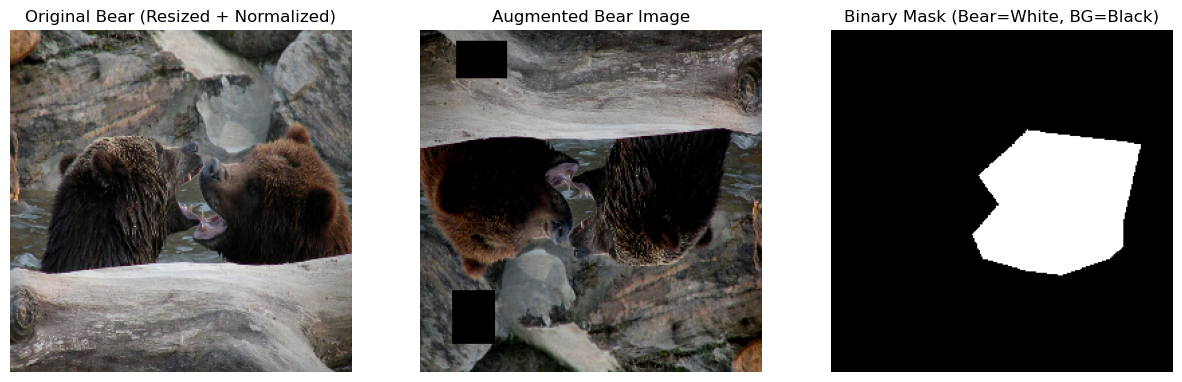

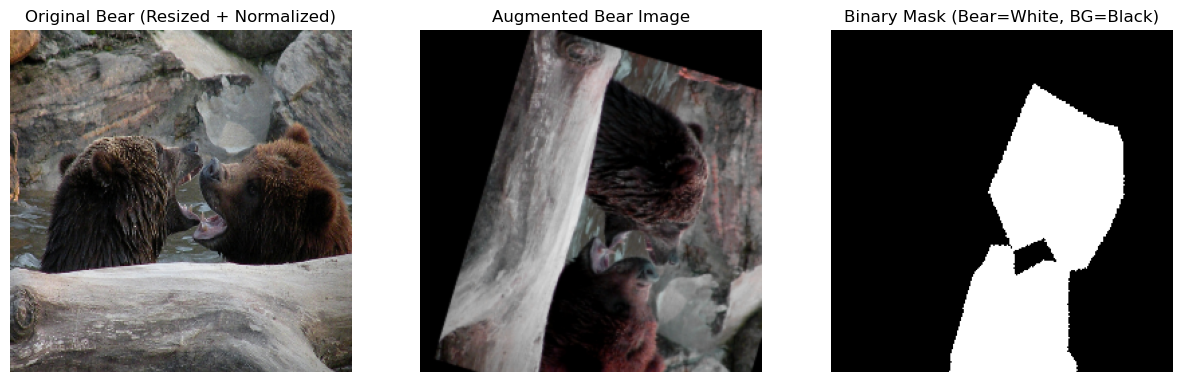

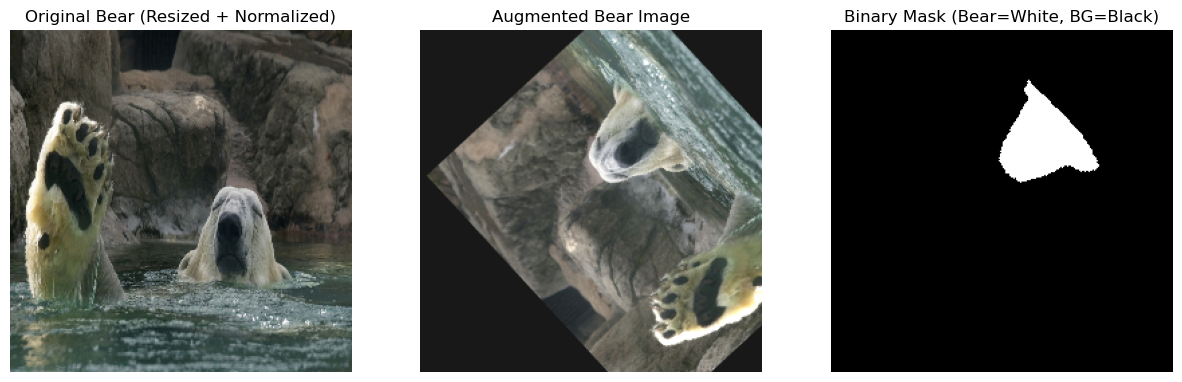

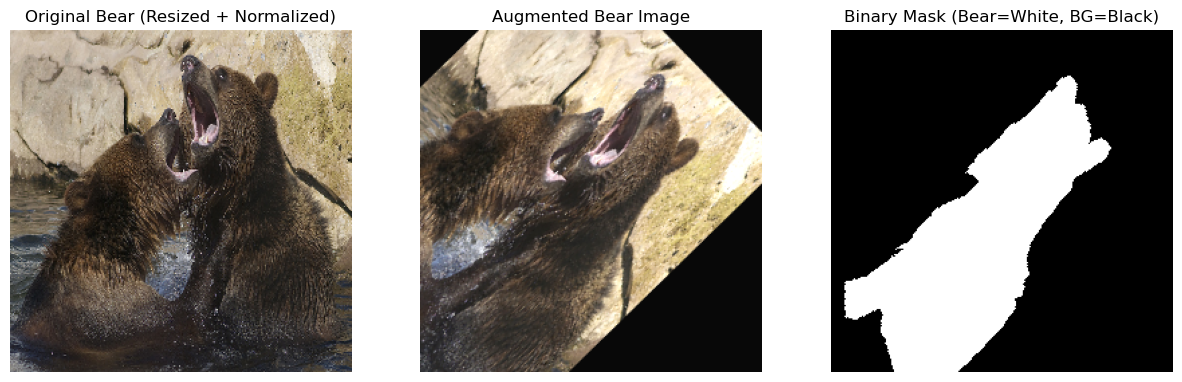

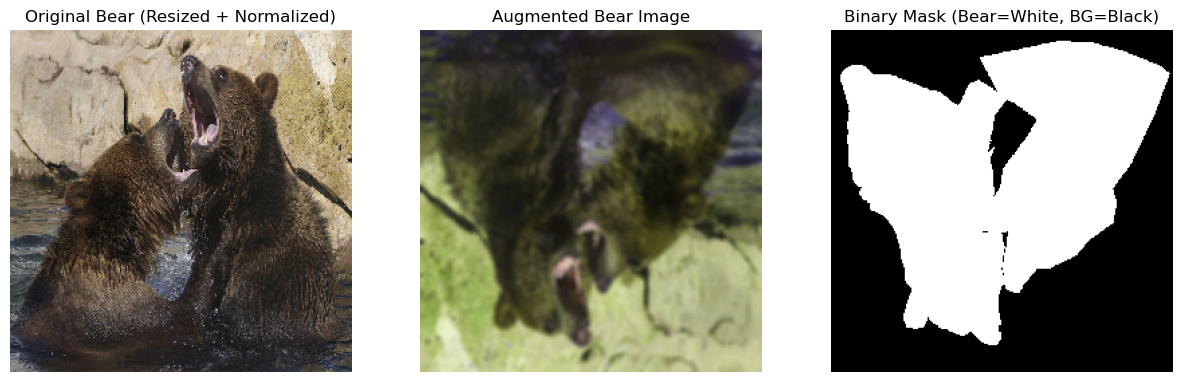

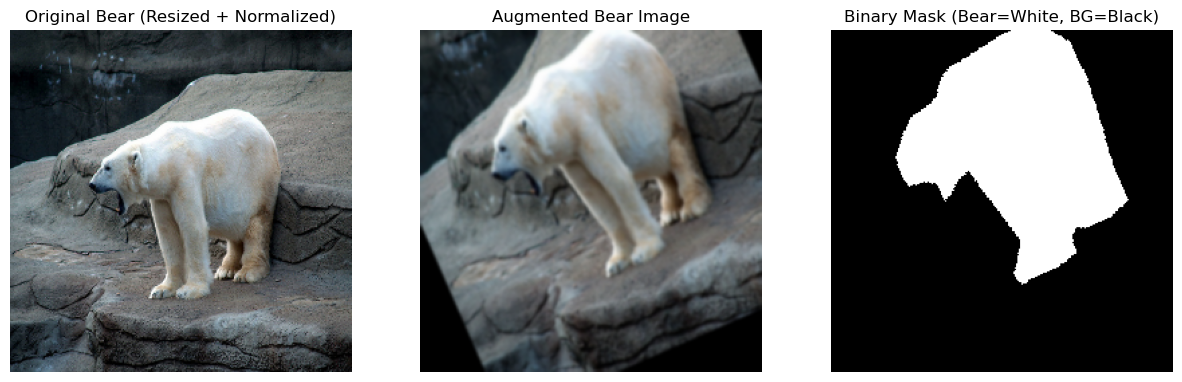

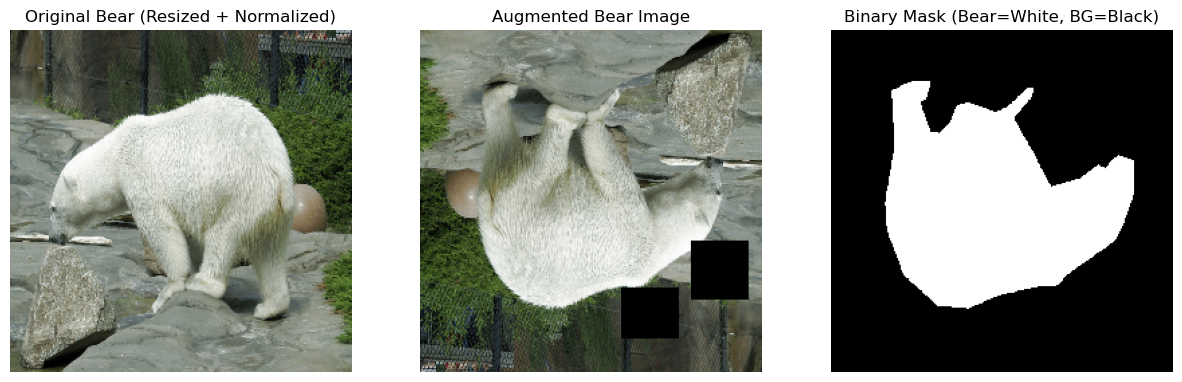

In [8]:
for idx, imgId in enumerate(sample_imgIds, 1):
    imgInfo = coco.loadImgs(imgId)[0]
    # Load image 
    imgPath = os.path.join(imgDir, imgInfo['file_name']) 
    image = cv2.cvtColor(cv2.imread(imgPath), cv2.COLOR_BGR2RGB)
    # Load bear annotations 
    annIds = coco.getAnnIds(imgIds=imgInfo['id'], catIds=[bear_catId]) 
    anns = coco.loadAnns(annIds) 
    # Build binary mask(bear=1, background=0) 
    mask = np.zeros((imgInfo['height'], imgInfo['width']), dtype=np.uint8) 
    for ann in anns: 
        mask = np.maximum(mask, coco.annToMask(ann).astype(np.uint8)) 
        # Resize + normalize image 
        image_resized = cv2.resize(image, (255, 255)).astype(np.float32) / 255.0 
        mask_resized = cv2.resize(mask, (255, 255), interpolation=cv2.INTER_NEAREST) 
        # Binary mask (bear=white, background=black) 
        binary_mask = (mask_resized * 255).astype(np.uint8) 
        # ============================ 
        # Apply augmentation 
        # ============================ 
        augmented = transform(image=image, mask=mask) 
        aug_img, aug_mask = augmented["image"], augmented["mask"] 
        aug_img_norm = aug_img.astype(np.float32) / 255.0 
        aug_binary_mask = (aug_mask * 255).astype(np.uint8) 
        # ============================ 
        # Show results 
        # ============================ 
        fig, ax = plt.subplots(1, 3, figsize=(15, 5)) 
        ax[0].imshow(image_resized) 
        ax[0].set_title("Original Bear (Resized + Normalized)") 
        ax[0].axis("off") 
        ax[1].imshow(aug_img_norm) 
        ax[1].set_title("Augmented Bear Image") 
        ax[1].axis("off") 
        ax[2].imshow(aug_binary_mask, cmap="gray") 
        ax[2].set_title("Binary Mask (Bear=White, BG=Black)") 
        ax[2].axis("off") 
        plt.show()